- NLP에서 기본 전처리 관련하여 공부한 내용 입니다 



NLP는?
NLP(자연어처리)는 텍스트 문제에 접근하기 위한 기술집합이다.
이 튜토리얼에서는 IMDB 영화 리뷰를 로딩하고 정제하고 간단한 BOW(Bag of Words) 모델을 적용하여 리뷰가 추천인지 아닌지에 대한 정확도를 예측한다.



In [ ]:
import pandas as pd

"""
header = 0 은 파일의 첫 번째 줄에 열 이름이 있음을 나타내며 
delimiter = \t 는 필드가 탭으로 구분되는 것을 의미한다.
quoting = 3은 쌍따옴표를 무시하도록 한다. : 걍 양쪽 쌍따옴표 없애는거임
"""
# QUOTE_MINIMAL (0), QUOTE_ALL (1), 
# QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

# 레이블인 sentiment 가 있는 학습 데이터
train = pd.read_csv('https://github.com/corazzon/KaggleStruggle/raw/master/word2vec-nlp-tutorial/data/labeledTrainData.tsv', delimiter='\t', quoting=3)
train_wiothout_quoting = pd.read_csv('https://github.com/corazzon/KaggleStruggle/raw/master/word2vec-nlp-tutorial/data/labeledTrainData.tsv', delimiter='\t')
# 레이블이 없는 테스트 데이터
test = pd.read_csv('https://github.com/corazzon/KaggleStruggle/raw/master/word2vec-nlp-tutorial/data/testData.tsv', delimiter='\t', quoting=3)
train.shape

(25000, 3)

In [ ]:
train.tail(3) # 이렇게 review가 sentiment (리뷰가 긍정인지 부정인지 긍정1)

,id,sentiment,review
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."
24999,"""8478_8""",1,"""I saw this movie as a child and it broke my h..."


In [ ]:
test.shape

(25000, 2)

In [ ]:
test.tail()

,id,review
24995,"""2155_10""","""Sony Pictures Classics, I'm looking at you! S..."
24996,"""59_10""","""I always felt that Ms. Merkerson had never go..."
24997,"""2531_1""","""I was so disappointed in this movie. I am ver..."
24998,"""7772_8""","""From the opening sequence, filled with black ..."
24999,"""11465_10""","""This is a great horror film for people who do..."


In [ ]:
train.columns.values

array([' id', 'sentiment', 'review'], dtype=object)

In [ ]:
# 레이블인 'sentiment'가 없다. 이 데이터를 기계학습을 통해 예측한다.
test.columns.values

array(['id', 'review'], dtype=object)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0    id        25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [ ]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [ ]:
import numpy as np
train.describe(exclude=[np.number])

,id,review
count,25000,25000
unique,25000,24904
top,"""5814_8""","""When i got this movie free from my job, along..."
freq,1,3


In [ ]:
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [ ]:
# html 태그가 섞여있기 때문에 이를 정제해줄 필요가 있음
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

### 데이터 정제 Data Cleaning and Text Preprocessing
기계가 텍스트를 이해할 수 있도록 텍스트를 정제해 준다.

신호와 소음을 구분한다. 아웃라이어데이터로 인한 오버피팅을 방지한다.

1. BeautifulSoup(뷰티풀숩)을 통해 **HTML 태그를 제거**
2. 정규표현식으로 알파벳 이외의 문자를 공백으로 치환 **(각종 특수문자 제거)**
3. NLTK 데이터를 사용해 **불용어(Stopword)를 제거**
4. 어간추출(스테밍 Stemming)과 음소표기법(Lemmatizing)의 개념을 이해하고 SnowballStemmer를 통해 **어간을 추출**


### 텍스트 데이터 전처리 이해하기 (밑부분서 함수 하나로 정리할 예정)


**정규화 normalization (입니닼ㅋㅋ -> 입니다 ㅋㅋ, 샤릉해 -> 사랑해)**

* 한국어를 처리하는 예시입니닼ㅋㅋㅋㅋㅋ -> 한국어를 처리하는 예시입니다 ㅋㅋ

**토큰화 tokenization**

* 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하는Verb, 예시Noun, 입Adjective, 니다Eomi ㅋㅋKoreanParticle

**어근화 stemming (입니다 -> 이다)**

* 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하다Verb, 예시Noun, 이다Adjective, ㅋㅋKoreanParticle


**어구 추출 phrase extraction** 

* 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어, 처리, 예시, 처리하는 예시

Introductory Presentation: [Google Slides](https://docs.google.com/presentation/d/10CZj8ry03oCk_Jqw879HFELzOLjJZ0EOi4KJbtRSIeU/)

* 뷰티풀숩이 설치되지 않았다면 우선 설치해 준다.
```
!pip install BeautifulSoup4
```

In [ ]:
# 설치 및 버전확인
!pip show BeautifulSoup4

Name: beautifulsoup4
Version: 4.6.3
Summary: Screen-scraping library
Home-page: http://www.crummy.com/software/BeautifulSoup/bs4/
Author: Leonard Richardson
Author-email: leonardr@segfault.org
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: google, gdown, fastai, bs4


In [ ]:
from bs4 import BeautifulSoup

example1 = BeautifulSoup(train['review'][0], "html5lib")
print(f'bs로 html 태그 제거 전 : {train["review"][0][:700]}')
print(f'태그 제거 후 : {example1.get_text()[:700]}') # 700은 너무 기니까 그냥 700개 까지 본거임

bs로 html 태그 제거 전 : "With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik
태그 제거 후 : "With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool i

In [ ]:
# 정규표현식을 사용해서 특수문자를 제거
import re
# 소문자와 대문자가 아닌 것은 공백으로 대체한다 => 특수문자는 공백으로 바꾼다는 말임
letters_only = re.sub('[^a-zA-Z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [ ]:
# 모두 소문자로 변환한다 : 대소문자를 서로 다른문자로 인식할 수 있으므로
lower_case = letters_only.lower()
# 문자를 나눈다. => 토큰화
words = lower_case.split()
print(len(words))
print('토근화 적용')
words[:10]

437
토근화 적용


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

### 불용어 제거(Stopword Removal)
- **그냥 쓸데없는 말 제거** 한단거임
- nltk라는 패키지가 영어 불용어 정리된 라이브러리. 한국어는 없다 

일반적으로 코퍼스에서 자주 나타나는 단어는 학습 모델로서 학습이나 예측 프로세스에 실제로 기여하지 않아 다른 텍스트와 구별하지 못한다. 예를들어 조사, 접미사, i, me, my, it, this, that, is, are 등 과 같은 단어는 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는다. Stopwords는 "to"또는 "the"와 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋다. NLTK에는 153 개의 영어 불용어가 미리 정의되어 있다. 17개의 언어에 대해 정의되어 있으며 한국어는 없다.


### NLTK data 설치 
* http://corazzon.github.io/nltk_data_install 

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
# stopwords 를 제거한 토큰들
words = [w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

### 스테밍(어간추출, 형태소 분석)
- **running, runs -> run 이 작업을 스테밍(어간추출)**이라고 함
- nltk 에서 제공하는 방법을 사용하면 됨. 다만 내부적으로 두 종류가 있는데 어떤 방법을 사용하느냐에 따라 적극성이 달라짐

출처 : [어간 추출 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EC%96%B4%EA%B0%84_%EC%B6%94%EC%B6%9C)


* 어간 추출(語幹 抽出, 영어: stemming)은 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것
* "message", "messages", "messaging" 과 같이 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있도록 도와준다.
* stemming(형태소 분석): 여기에서는 NLTK에서 제공하는 형태소 분석기를 사용한다. 포터 형태소 분석기는 보수적이고 랭커스터 형태소 분석기는 좀 더 적극적이다. 형태소 분석 규칙의 적극성 때문에 랭커스터 형태소 분석기는 더 많은 동음이의어 형태소를 생산한다. [참고 : 모두의 데이터 과학 with 파이썬(길벗)](http://www.gilbut.co.kr/book/bookView.aspx?bookcode=BN001787)

In [ ]:
# 포터 스태머의 사용 예
stemmer = nltk.stem.PorterStemmer()
print(f'포터 스태머를 사용한 경우 :{stemmer.stem("maximum")}')
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

포터 스태머를 사용한 경우 :maximum
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [ ]:
# 랭커스터 스태머의 사용 예
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
print(f'랭커스터 스태머를 사용한 경우 :{lancaster_stemmer.stem("maximum")}')
print("The stemmed form of running is: {}".format(lancaster_stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(lancaster_stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(lancaster_stemmer.stem("run")))

랭커스터 스태머를 사용한 경우 :maxim
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [ ]:
# 처리 전 단어
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [ ]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]
# 처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

### Lemmatization 음소표기법

언어학에서 음소 표기법 (또는 lemmatization)은 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절 된 형태의 단어를 그룹화하는 과정이다. 
예를 들어 동음이의어가 문맥에 따라 다른 의미를 갖는데 
<pre>
1) *배*가 맛있다. 
2) *배*를 타는 것이 재미있다. 
3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.
</pre>
위에 있는 3개의 문장에 있는 "배"는 모두 다른 의미를 갖는다. <br/>
레마타이제이션은 이때 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다.
영어에서 meet는 meeting으로 쓰였을 때 회의를 뜻하지만 meet 일 때는 만나다는 뜻을 갖는데 그 단어가 명사로 쓰였는지 동사로 쓰였는지에 따라 적합한 의미를 갖도록 추출하는 것이다.

* 참고 : 
    - [Stemming and lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)
    - [Lemmatisation - Wikipedia](https://en.wikipedia.org/wiki/Lemmatisation)

In [ ]:
print('레마타이제이션 적용 전')
words[:10]

레마타이제이션 적용 전


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

print(wordnet_lemmatizer.lemmatize('fly'))
print(wordnet_lemmatizer.lemmatize('flies'))

words = [wordnet_lemmatizer.lemmatize(w) for w in words]
# 처리 후 단어
words[:10]

fly
fly


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

* 하지만 이 튜토리얼에서는 Stemming과 Lemmatizing을 소개만 해서 stemming 코드를 별도로 추가하였다.


# 문자열 처리
*  위에서 간략하게 살펴본 내용을 바탕으로 문자열을 처리해 본다.

In [ ]:
def review_to_words( raw_review ):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    # stopwords 를 세트로 변환한다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 불용어 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return( ' '.join(stemming_words) )

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [ ]:
# 첫 번째 리뷰를 대상으로 전처리 해줬던 내용을 전체 텍스트 데이터를 대상으로 처리한다.
# 전체 리뷰 데이터 수 가져오기
num_reviews = train['review'].size
num_reviews

25000

In [ ]:
"""
clean_train_reviews = []
캐글 튜토리얼에는 range가 xrange로 되어있지만 
여기에서는 python3를 사용하기 때문에 range를 사용했다.
"""
# for i in range(0, num_reviews):
#     clean_train_reviews.append( review_to_words(train['review'][i]))
"""
하지만 위 코드는 어느 정도 실행이 되고 있는지 알 수가 없어서
5000개 단위로 상태를 찍도록 개선했다.
"""
# clean_train_reviews = []
# for i in range(0, num_reviews):
#     if (i + 1)%5000 == 0:
#         print('Review {} of {} '.format(i+1, num_reviews))
#     clean_train_reviews.append(review_to_words(train['review'][i]))
    
"""
그리고 코드를 좀 더 간결하게 하기 위해 for loop를 사용하는 
대신 apply를 사용하도록 개선
"""    
# %time train['review_clean'] = train['review'].apply(review_to_words)
"""
코드는 한 줄로 간결해 졌지만 여전히 오래 걸림
"""
# CPU times: user 1min 15s, sys: 2.3 s, total: 1min 18s
# Wall time: 1min 20s


'\n코드는 한 줄로 간결해 졌지만 여전히 오래 걸림\n'

In [ ]:
# 참고 : https://gist.github.com/yong27/7869662
# http://www.racketracer.com/2016/07/06/pandas-in-parallel/
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
%time clean_train_reviews = apply_by_multiprocessing(\
    train['review'], review_to_words, workers=4)  

CPU times: user 484 ms, sys: 207 ms, total: 690 ms
Wall time: 53.6 s


In [ ]:
%time clean_test_reviews = apply_by_multiprocessing(\
    test['review'], review_to_words, workers=4)    

CPU times: user 435 ms, sys: 194 ms, total: 628 ms
Wall time: 54.6 s


### 워드 클라우드 (태윤이가 좋아하는 시각화 방법)
- 단어의 빈도 수 데이터를 가지고 있을 때 이용할 수 있는 시각화 방법
- 단순히 빈도 수를 표현하기 보다는 상관관계나 유사도 등으로 배치하는 게 더 의미 있기 때문에 큰 정보를 얻기는 어렵다.

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# %matplotlib inline 설정을 해주어야지만 노트북 안에 그래프가 디스플레이 된다.
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

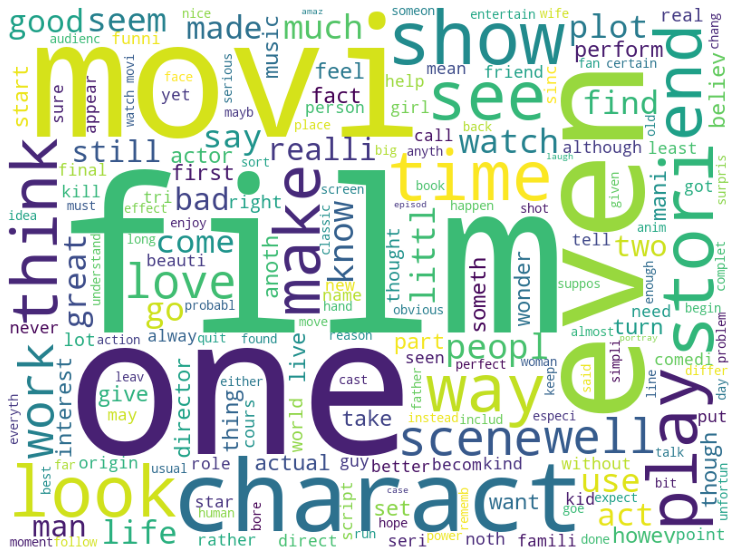

CPU times: user 22.7 s, sys: 1.31 s, total: 24 s
Wall time: 23.9 s


In [ ]:
# 학습 데이터의 모든 단어에 대한 워드 클라우드를 그려본다.
%time displayWordCloud(' '.join(clean_train_reviews))

In [ ]:
# 단어 수
train['num_words'] = clean_train_reviews.apply(lambda x: len(str(x).split()))
# 중복을 제거한 단어 수
train['num_uniq_words'] = clean_train_reviews.apply(lambda x: len(set(str(x).split())))

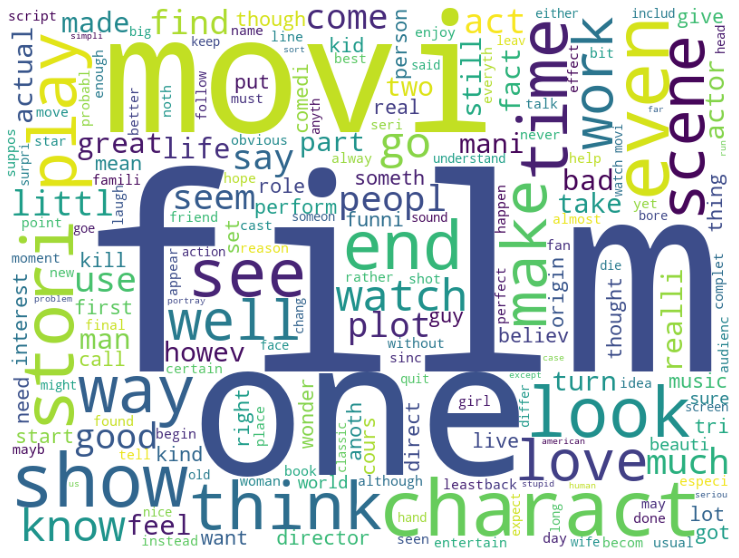

CPU times: user 21.7 s, sys: 754 ms, total: 22.4 s
Wall time: 22.5 s


In [ ]:
# 테스트 데이터의 모든 단어에 대한 워드 클라우드를 그려본다.
%time displayWordCloud(' '.join(clean_test_reviews))

In [ ]:
# 첫 번째 리뷰에 
x = clean_train_reviews[0]
x = str(x).split()
print(len(x))
x[:10]

219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

리뷰별 단어 평균 값 : 119.52356
리뷰별 단어 중간 값 89.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


review unique word mean : 94.05756
review unique word median 74.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'review unique word distribution')

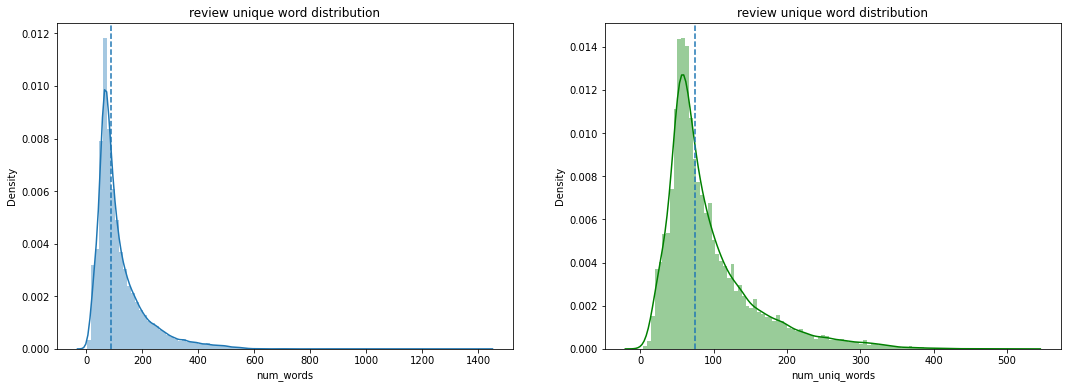

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18, 6)
print('리뷰별 단어 평균 값 :', train['num_words'].mean())
print('리뷰별 단어 중간 값', train['num_words'].median())
sns.distplot(train['num_words'], bins=100, ax=axes[0])
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('review unique word distribution')

print('review unique word mean :', train['num_uniq_words'].mean())
print('review unique word median', train['num_uniq_words'].median())
sns.distplot(train['num_uniq_words'], bins=100, color='g', ax=axes[1])
axes[1].axvline(train['num_uniq_words'].median(), linestyle='dashed')
axes[1].set_title('review unique word distribution')

### [Bag-of-words model - Wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model) : **머신러닝이 이해할 수 있도록 변환해주는 작업** 

다음의 두 문장이 있다고 하자,
```
(1) John likes to watch movies. Mary likes movies too.
(2) John also likes to watch football games.
```
위 두 문장을 토큰화 하여 (unique : 고유하게) 가방에 담아주면 다음과 같다.

```
[
    "John",
    "likes",
    "to",
    "watch",
    "movies",
    "Mary",
    "too",
    "also",
    "football",
    "games"
]
```

그리고 배열의 순서대로 가방에서 각 토큰이 몇 번 등장하는지 횟수를 세어준다.
```
(1) [1, 2, 1, 1, 2, 1, 1, 0, 0, 0]
(2) [1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
```
=> 머신러닝 알고리즘이 이해할 수 있는 형태로 바꿔주는 작업이다.

단어 가방을 n-gram을 사용해 bigram(bigram은 단어 두개를 하나로, trigran은 단어 세개를 하나로) 으로 담아주면 다음과 같다.
```
[
    "John likes",
    "likes to",
    "to watch",
    "watch movies",
    "Mary likes",
    "likes movies",
    "movies too",
]
```
=> 여기에서는 CountVectorizer를 통해 위 작업을 한다.


### **사이킷런의 CountVectorizer를 통해 피처 생성**
* 정규표현식을 사용해 토큰을 추출한다.
* 모두 소문자로 변환시키기 때문에 good, Good, gOod이 모두 같은 특성이 된다.
* 의미없는 특성을 많이 생성하기 때문에 적어도 두 개의 문서에 나타난 토큰만을 사용한다.
* min_df로 토큰이 나타날 최소 문서 개수를 지정할 수 있다.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# 튜토리얼과 다르게 파라메터 값을 수정
# 파라메터 값만 수정해도 캐글 스코어 차이가 많이 남
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수 (문서가 뭔말인지 모르겠음)
                             ngram_range=(1, 3),
                             max_features = 20000 # 가방의 용량이라고 보면됨
                            )
vectorizer

CountVectorizer(max_features=20000, min_df=2, ngram_range=(1, 3))

In [ ]:
# 속도 개선을 위해 파이프라인을 사용하도록 개선
# 참고 : https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph
pipeline = Pipeline([
    ('vect', vectorizer),
])  

In [ ]:
%time train_data_features = pipeline.fit_transform(clean_train_reviews)
train_data_features

CPU times: user 35.6 s, sys: 799 ms, total: 36.4 s
Wall time: 37.1 s


<25000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2762268 stored elements in Compressed Sparse Row format>

* 보통 fit을 학습하는데 사용하는데 여기에서는 벡터화 할 때도 fit을 사용했습니다. 사이킷런에 구현된 벡터화 알고리즘이 fit을 사용해서 벡터화 하도록 되어 있습니다. 따라서 RF에서의 fit과 벡터화에 사용되는 fit은 다른 성격입니다.

##  pipeline
* **영상에 성능을 위해 pipeline을 사용했다는 말이 있는데 이 부분을 정정합니다.**
* 아래의 공식 문서를 보면 pipeline 에서 메모리의 캐시를 사용할 수 있다는 문구도 있습니다. 하지만 성능상의 이슈라기보다는 cross-validation 과 GridSearch 과정을 하나로 만들어 주는게 pipeline의 가장 큰 장점이라고 합니다. **저는 하나의 과정만 묶어줘서 사실 굳이 pipeline을 쓸 필요는 없는데 보통 transform 하는 과정에서 pipeline을 사용합니다.**


* 제 코드에는 cross-validation 과 GridSearch 과정이 없는데 해당 과정은 모델의 성능(정확도)를 측정해 보는 과정이고, GridSearch는 최적의 하이퍼파라메터를 찾는 과정입니다.

* Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. The transformers in the pipeline can be cached using memory argument.


* 더 읽어보기 : https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [ ]:
train_data_features.shape

(25000, 20000)

In [ ]:
vocab = vectorizer.get_feature_names() # 이게 단어사전 (사용된 단어들이 있는 목록)
print(len(vocab))
vocab[:10]

20000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [ ]:
# 벡터화 된 피처를 확인해 봄 (각 단어가 몇번 썼는지 보는건데 그냥 찍으면 ndarray로 나오니까 잘 보려고 판다스로 만든거임)
import numpy as np
dist = np.sum(train_data_features, axis=0)
    
for tag, count in zip(vocab, dist): # zip 같은 문법도 이제 익숙해지자 
    print(count, tag)
    
pd.DataFrame(dist, columns=vocab)

[[26 48 22 ... 59 40 23]] aag


,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,...,23,52,37,89,161,31,71,59,40,23


In [ ]:
pd.DataFrame(train_data_features[:10].toarray(), columns=vocab).head() # 이거는 row 별로 본거임 

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### [랜덤 포레스트 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8)
랜덤 포레스트의 가장 핵심적인 특징은 임의성(randomness)에 의해 서로 조금씩 다른 특성을 갖는 트리들로 구성된다는 점이다. 이 특징은 각 트리들의 예측(prediction)들이 비상관화(decorrelation) 되게하며, 결과적으로 일반화(generalization) 성능을 향상시킨다. 또한, 임의화(randomization)는 포레스트가 노이즈가 포함된 데이터에 대해서도 강하게 만들어 준다.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(n_jobs=-1, random_state=2018)

In [ ]:
%time forest = forest.fit(train_data_features, train['sentiment'])

CPU times: user 1min 22s, sys: 122 ms, total: 1min 22s
Wall time: 42.2 s


In [ ]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, train_data_features, \
    train['sentiment'], cv=10, scoring='roc_auc'))
score

CPU times: user 12.5 s, sys: 1.48 s, total: 13.9 s
Wall time: 6min 24s


0.92761104

# 예측

In [ ]:
# 위에서 정제해준 리뷰의 첫 번째 데이터를 확인
clean_test_reviews[0]

'natur film main theme mortal nostalgia loss innoc perhap surpris rate high older viewer younger one howev craftsmanship complet film anyon enjoy pace steadi constant charact full engag relationship interact natur show need flood tear show emot scream show fear shout show disput violenc show anger natur joyc short stori lend film readi made structur perfect polish diamond small chang huston make inclus poem fit neat truli masterpiec tact subtleti overwhelm beauti'

In [ ]:
# 테스트 데이터를 벡터화 함
%time test_data_features = pipeline.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

CPU times: user 7.83 s, sys: 44.8 ms, total: 7.88 s
Wall time: 7.89 s


In [ ]:
test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# 벡터화 된 단어로 숫자가 문서에서 등장하는 횟수를 나타낸다
test_data_features[5][:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# 벡터화 하며 만든 사전에서 해당 단어가 무엇인지 찾아볼 수 있다.
# vocab = vectorizer.get_feature_names()
vocab[8], vocab[2558], vocab[2559], vocab[2560]

('abc', 'charact person', 'charact play', 'charact plot')

In [ ]:
# 테스트 데이터를 넣고 예측한다.
result = forest.predict(test_data_features)
result[:10]

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0])

# 캐글 제출을 위해 예측결과 저장

In [ ]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'id':test['id'], 'sentiment':result})
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",0
3,"""7186_2""",1
4,"""12128_7""",1


In [ ]:
output.to_csv('tutorial_1_BOW_{0:.5f}.csv'.format(score), index=False, quoting=3)

In [ ]:
output_sentiment = output['sentiment'].value_counts()
print(np.abs(output_sentiment[0] - output_sentiment[1]))
output_sentiment

108


0    12554
1    12446
Name: sentiment, dtype: int64

## Train, Test의 감정분류 결과 값 비교

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


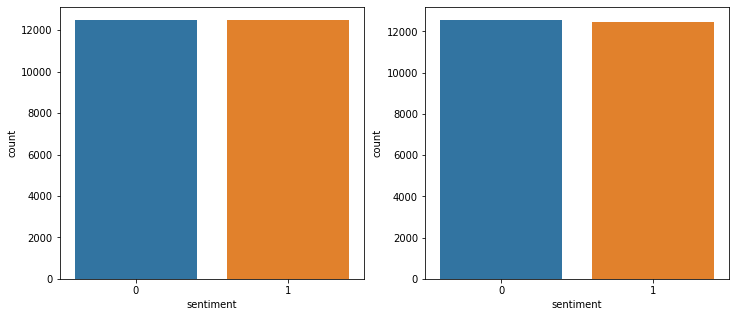

In [ ]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

첫 번째 제출을 할 준비가 되었다.
리뷰를 다르게 정리하거나 'Bag of Words' 표현을 위해 다른 수의 어휘 단어를 선택하거나 포터 스테밍 등을 시도해 볼 수 있다.
다른 데이터세트로 NLP를 시도해 보려면 로튼 토마토(Rotten Tomatoes)를 해보는 것도 좋다.

* 로튼 토마토 데이터 셋을 사용하는 경진대회 : [Sentiment Analysis on Movie Reviews | Kaggle](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)

## 캐글 제출 결과

In [ ]:
# 파라메터를 조정해 가며 점수를 조금씩 올려본다.

# uni-gram 사용 시 캐글 점수 0.84476
print(436/578)
# tri-gram 사용 시 캐글 점수 0.84608
print(388/578)
# 어간추출 후 캐글 점수 0.84780
print(339/578)
# 랜덤포레스트의 max_depth = 5 로 지정하고
# CountVectorizer의 tokenizer=nltk.word_tokenize 를 지정 후 캐글 점수 0.81460
print(546/578)
# 랜덤포레스트의 max_depth = 5 는 다시 None으로 변경
# CountVectorizer max_features = 10000개로 변경 후 캐글 점수 0.85272
print(321/578)
# CountVectorizer의 tokenizer=nltk.word_tokenize 를 지정 후 캐글 점수 0.85044
print(326/578)
# CountVectorizer max_features = 10000개로 변경 후 캐글 점수 0.85612
print(305/578)
# 0.85884
print(296/578)

print(310/578)

0.754325259515571
0.671280276816609
0.5865051903114187
0.9446366782006921
0.5553633217993079
0.5640138408304498
0.527681660899654
0.5121107266435986
0.5363321799307958
